<a href="https://colab.research.google.com/github/nihermann/Pokemaenner/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import time
import PIL
from IPython import display
#if not already installed
# !pip install -q git+https://github.com/tensorflow/docs 
import tensorflow_docs.vis.embed as embed
from keras.utils.vis_utils import plot_model


     |████████████████████████████████| 1.0MB 4.4MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# preparing the dataset
dataset = (
    "/content/drive/MyDrive/pokemaenner/data_white", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(lambda x: x / 255.0)

Found 10119 files belonging to 1 classes.


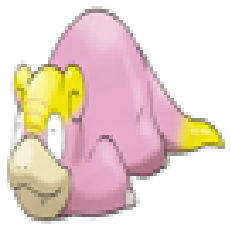

In [ ]:
# displaying the data
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
epochs = 200
latent_dim = 128

In [ ]:
# discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.Dropout(0.4),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.Dropout(0.4),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# generator
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)       

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 32, 32, 256)       524544    
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 256)       10

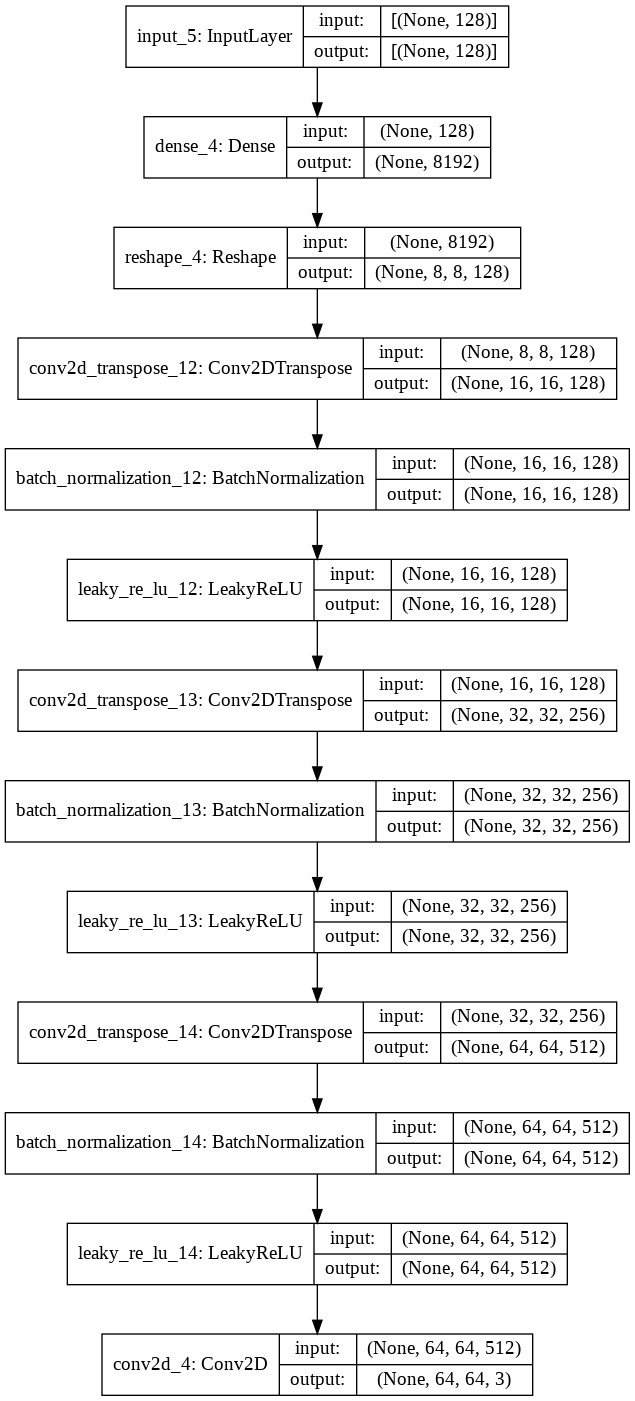

In [ ]:
# generator
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

# plot the model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
class GAN(keras.Model):
    '''Class to define a generative adversarial network combining both 
     discriminator and generator.'''
    def __init__(self, discriminator, generator, latent_dim):
        '''discriminator and genereator are predefines models and latent_dim 
         defines the dimension of the latent space'''
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        '''Returns the loss metric of both discriminator and the generator'''
        return [self.d_loss_metric, self.g_loss_metric]


    # overriding the train_step
    def train_step(self, real_images):
        '''Trains both the discriminator and the generator'''
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode the vectors from the latent space to fake images by calling
        # the generator
        generated_images = self.generator(random_latent_vectors)

        # Concatenate the real images from the given dataset and the generated ones 
        # from the latent space
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images 
        # generated images are labeled with one while real ones with 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            # get the predictions of each image from both the real and generated
            # images
            predictions = self.discriminator(combined_images)
            # compoute the loss of the discriminator for the given loss function
            # (vanilla is binary cross entroy) with the correct target (the labels)
            # and the given classification of the discriminator
            d_loss = self.loss_fn(labels, predictions)
        # train the weights (trainable being the ones from the convolutional layers)
        # and apply the optimizer gradients 
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images" (0) (the generator hopes to
        # fool the discriminator)
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            # get the predictions of the discriminator for the generated images
            # (whether or not the discriminator fell for the fake ones)
            predictions = self.discriminator(self.generator(random_latent_vectors))
            # compute the loss for only correct labels and the actual times the 
            # generator trickes the discriminator
            g_loss = self.loss_fn(misleading_labels, predictions)
        # train the weights of the transposed convolutional layers with gradient
        # tape and the given optimizer
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

NameError: ignored

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    '''Manages what to do with the GAN and it's result after each epoch
     (make a checkpoint and save the generated images.'''
    def __init__(self, num_img=3, latent_dim=128, checkpoint_path = "/content/drive/MyDrive/pokemaenner/model/training_1/cp.ckpt", epoch_counter_begin = 0):
        ''' :param num_img = how many images to save
            :param latent_dim = size of the latent space
            :param checkpoint_path = path for saving the epoch checkpoint
            :param epoch_counter_begin = where the training was left off 
            (to save the images under the correct file name) 
        '''
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.checkpoint_path = checkpoint_path
        self.epoch_counter_begin = epoch_counter_begin


    def on_epoch_end(self, epoch, logs=None):
        # make Checkpoint
        tf.keras.callbacks.ModelCheckpoint(filepath=self.checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
        # generate images from random noise with the generator
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        # unnormalize the images to get the full color coding
        generated_images *= 255
        #as numpy 
        generated_images.numpy()
        for i in range(self.num_img):
            # save images 
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/drive/MyDrive/pokemaenner/wasserstein/results/generated_img_%03d_%d.png" % (epoch + self.epoch_counter_begin, i))            


IndentationError: ignored

In [ ]:
# initialize the gan with the generator and the discriminator as well as the 
# given size of dimension in the latent space
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#compile the model with Adam optimizer and the Binary Crossentropy loss function
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# fit the model with the overridden training function
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

In [ ]:
# save the weights of the gan so you can continue training after the model is
# finished
gan.save_weights("/content/drive/MyDrive/pokemaenner/model/gan_model", save_format='tf')

In [ ]:
# Continure training: 
# Recreate the model
new_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# compile the model with the same attributes as the original model (especially
# latent space if not it won't work)
new_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Load the state of the old model
new_gan.load_weights('/content/drive/MyDrive/pokemaenner/model/gan_model')


In [ ]:
# continue to fit the model with the weights from the old model were you left of
# to get correct image labelling definde the epoch_counter_begin as the number
# of epochs of you last training 
new_gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/200
317/317 [==============================] - 2571s 8s/step - d_loss: 0.6955 - g_loss: 0.8907
Epoch 2/200
317/317 [==============================] - 89s 278ms/step - d_loss: 0.7074 - g_loss: 0.8467
Epoch 3/200
317/317 [==============================] - 91s 286ms/step - d_loss: 0.6923 - g_loss: 0.8151
Epoch 4/200
317/317 [==============================] - 92s 290ms/step - d_loss: 0.7031 - g_loss: 0.8235
Epoch 5/200
317/317 [==============================] - 93s 292ms/step - d_loss: 0.7039 - g_loss: 0.7644
Epoch 6/200
317/317 [==============================] - 93s 293ms/step - d_loss: 0.7018 - g_loss: 0.7968
Epoch 7/200
317/317 [==============================] - 93s 292ms/step - d_loss: 0.6661 - g_loss: 0.8730
Epoch 8/200
317/317 [==============================] - 93s 293ms/step - d_loss: 0.6988 - g_loss: 0.8068
Epoch 9/200
317/317 [==============================] - 93s 293ms/step - d_loss: 0.6756 - g_loss: 0.8852
Epoch 10/200
317/317 [==============================] - 93s 294ms